# Bootstrap sampling over baseline pairs
This example shows how to estimate bootstrap errorbars for an average 1D delay power spectrum.

In [1]:
%matplotlib inline
from pyuvdata import UVData, uvutils
import hera_pspec as hp
from hera_cal import redcal
import numpy as np
import matplotlib.pyplot as plt

## Loading data and generating power spectra
We will begin by loading 'even' and 'odd' data files and using those to create delay power spectra for a set of redundant baseline pairs. We only do this for one polarization ('xx'), and a couple of spectral windows.

In [2]:
# Select even and odd data files to load
dfiles = ['../hera_pspec/data/zen.even.xx.LST.1.28828.uvOCRSA',
          '../hera_pspec/data/zen.odd.xx.LST.1.28828.uvOCRSA']

# Load into UVData objects
uvd_even, uvd_odd = UVData(), UVData()
uvd_even.read_miriad(dfiles[0])
uvd_odd.read_miriad(dfiles[1])

# Check which baselines are available
print "Available baselines:", len(uvd_even.get_antpairs())
print uvd_even.get_antpairs()

Available baselines: 55
[(37, 37), (37, 38), (37, 39), (37, 51), (37, 52), (37, 53), (37, 54), (37, 67), (37, 68), (37, 69), (38, 38), (38, 39), (38, 51), (38, 52), (38, 53), (38, 54), (38, 67), (38, 68), (38, 69), (39, 39), (39, 51), (39, 52), (39, 53), (39, 54), (39, 67), (39, 68), (39, 69), (51, 51), (51, 52), (51, 53), (51, 54), (51, 67), (51, 68), (51, 69), (52, 52), (52, 53), (52, 54), (52, 67), (52, 68), (52, 69), (53, 53), (53, 54), (53, 67), (53, 68), (53, 69), (54, 54), (54, 67), (54, 68), (54, 69), (67, 67), (67, 68), (67, 69), (68, 68), (68, 69), (69, 69)]


In [3]:
# Instantiate cosmology and beam
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = '../hera_pspec/data/NF_HERA_Beams.beamfits'
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

In [4]:
# Create a new PSpecData object
ds = hp.PSpecData(dsets=[uvd_even, uvd_odd], wgts=[None, None], beam=uvb)

# Phase to the first ('even') dataset
ds.rephase_to_dset(0)

Now the data have been loaded into a `PSpecData` object, we can define the redundant baseline group that we want to bootstrap over and generate a full set of power spectra for all baseline-pairs within that group.

In [5]:
# Get list of redundant baseline groups
antpos, ants = ds.dsets[0].get_ENU_antpos(pick_data_ants=True)
antpos = dict(zip(ants, antpos))
red_bls = redcal.get_pos_reds(antpos, bl_error_tol=1.0, low_hi=True)

# Print members of each redundant baseline group
for i, redgrp in enumerate(red_bls):
    print i, redgrp

0 [(52, 67), (53, 68), (37, 51), (38, 52), (39, 53), (54, 69)]
1 [(51, 67), (52, 68), (37, 52), (38, 53), (39, 54), (53, 69)]
2 [(67, 68), (68, 69), (37, 38), (38, 39), (51, 52), (52, 53), (53, 54)]
3 [(37, 67), (38, 68), (39, 69)]
4 [(53, 67), (54, 68), (38, 51), (39, 52)]
5 [(51, 68), (37, 53), (38, 54), (52, 69)]
6 [(67, 69), (37, 39), (51, 53), (52, 54)]
7 [(38, 67), (39, 68)]
8 [(37, 68), (38, 69)]
9 [(37, 54), (51, 69)]
10 [(39, 67)]
11 [(37, 69)]
12 [(54, 67), (39, 51)]
13 [(51, 54)]


In [6]:
# Select which spectral windows to use
spws = hp.utils.spw_range_from_freqs(uvd_odd, freq_range=[(160e6, 165e6), (165e6, 170e6)], bounds_error=True)

# Build a list of baseline pairs to calculate power spectra for
# All valid baseline pairs from the first redundant baseline group will be included
bls1, bls2, blpairs = hp.pspecdata.construct_blpairs(red_bls[0], exclude_auto_bls=True, exclude_permutations=True)
for blp in blpairs:
    print blp

((52, 67), (53, 68))
((52, 67), (37, 51))
((52, 67), (38, 52))
((52, 67), (39, 53))
((52, 67), (54, 69))
((53, 68), (37, 51))
((53, 68), (38, 52))
((53, 68), (39, 53))
((53, 68), (54, 69))
((37, 51), (38, 52))
((37, 51), (39, 53))
((37, 51), (54, 69))
((38, 52), (39, 53))
((38, 52), (54, 69))
((39, 53), (54, 69))


In [7]:
# Calculate power spectra for these baseline pairs, for both spectral windows defined above
uvp = ds.pspec(bls1, bls2, (0, 1), spw_ranges=spws, input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=False)

## Average power spectrum
Now, we will calculate the average of the power spectra that were just calculated. The average is taken over (redundant) baseline-pairs and times.

Note that `blpair_groups` should be a list of lists (where each list contains the set of baseline pairs that should be averaged together).

In [8]:
blpairs = sorted(blpairs) # It's useful to keep these sorted
uvp_avg = uvp.average_spectra(blpair_groups=[blpairs,], time_avg=True, inplace=False)

The averaged power spectra are output to a new `UVPSpec` object. For each group of baseline-pairs that were averaged together, the average is assigned to the first baseline-pair in the group. (Other baseline-pairs from the group are not present in the averaged `UVPSpec` object.)

In [9]:
# Show which baseline-pairs are available in the averaged UVPSpec object
# (Only one should be available, corresponding to the first blpair in the group)
print uvp_avg.blpair_array
print uvp_avg.blpair_to_antnums(uvp_avg.blpair_array[0])

[37051038052]
((37, 51), (38, 52))


In [10]:
# To get the averaged power spectrum, we have to get the data for this baseline-pair
key = (0, uvp_avg.blpair_array[0], 'xx') # key = (spw, blpair, pol)
ps_avg = uvp_avg.get_data(key)
print ps_avg.shape

(1, 50)


## Bootstrap-sampled average power spectrum
Now let's create a bootstrap realization of the average power spectrum. This is constructed by randomly selecting which baseline pairs contribute to the average.

The baseline pairs are sampled with replacement, so a given baseline pair can contribute multiple times for example, while others might not contribute at all in a given realization. Each realization of the average will be constructed from the same number of baseline-pairs as the normal average above though; it's just that some baseline-pairs might be repeated (or excluded).

The aim of this is to generate many bootstrap samples of the averaged power spectrum. The variance of these bootstrap samples can then be used to estimate the errors on the average power spectrum.

The following code generates a single bootstrap realization of the averaged power spectrum:

In [11]:
# Set the random seed
np.random.seed(10)

# Generate a bootstrap sample of the averaged power spectrum
uvp_boot_list, boot_wgts = hp.grouping.bootstrap_average_blpairs(uvp_list=[uvp,], blpair_groups=[blpairs,], 
                                                                 time_avg=True)

# uvp_boot_list is a list of UVPSpec objects with the same length as the input list (uvp_list)
print len(uvp_boot_list)
print uvp_boot_list[0].blpair_array

1
[37051038052]


Each `UVPSpec` in `uvp_boot_list` contains the averaged version of the corresponding `UVPSpec` object in the input list `uvp_list`. Each of these objects is averaged over a bootstrap realization of baseline-pairs.

The bootstrap sampling is done over all available blpairs in the specified `blpair_group` from all available `UVPSpec` objects though. So, each averaged power spectrum in the list may have been produced from a different number of blpairs each time. (The total number of blpairs used in the averages across all `UVPSpec` objects will be the same each time though.)

In this example, we only input one `UVPSpec` object, so the output list only contains a single `UVPSpec` object that contains the full bootstrap-sampled average of the power spectrum.

We can see which baseline-pairs contributed to this realization by inspecting the `boot_wgts` list. For each `UVPSpec` object in `uvp_boot_list`, this contains the weights that were used for each baseline-pair in each group.

In [12]:
# Print the weights for the first blpair group from the first input UVPSpec object
wgts = boot_wgts[0][0]
blps = blpairs # From the first blpair group only
for i, w in enumerate(wgts):
    print "blpair %s, weight: %d" % (blpairs[i], w)

print "-"*30
print "Sum of weights: %d" % np.sum(wgts)
print "No. of available blpairs: %d" % len(blpairs)

blpair ((37, 51), (38, 52)), weight: 2
blpair ((37, 51), (39, 53)), weight: 2
blpair ((37, 51), (54, 69)), weight: 0
blpair ((38, 52), (39, 53)), weight: 0
blpair ((38, 52), (54, 69)), weight: 1
blpair ((39, 53), (54, 69)), weight: 0
blpair ((52, 67), (37, 51)), weight: 0
blpair ((52, 67), (38, 52)), weight: 0
blpair ((52, 67), (39, 53)), weight: 1
blpair ((52, 67), (53, 68)), weight: 3
blpair ((52, 67), (54, 69)), weight: 1
blpair ((53, 68), (37, 51)), weight: 1
blpair ((53, 68), (38, 52)), weight: 1
blpair ((53, 68), (39, 53)), weight: 3
blpair ((53, 68), (54, 69)), weight: 0
------------------------------
Sum of weights: 15
No. of available blpairs: 15


As before, we can get the average power spectrum from the `UVPSpec` object by fetching the data from the first blpair in the group:

In [13]:
key = (0, uvp_boot_list[0].blpair_array[0], 'xx') # key = (spw, blpair, pol)
_ps = uvp_boot_list[0].get_data(key)
print _ps.shape

(1, 50)


## Estimating error bars from multiple bootstrap realizations
Now we can generate a large number of bootstrap samples of the averaged power spectrum. The standard deviation of this set of power spectra then gives us an estimate of the error bars on the averaged power spectrum.

In [14]:
np.random.seed(10) # Set random seed again

# Generate 100 bootstrap realizations
pspec_boots = []
for i in range(100):
    uvpboots, _wgts = hp.grouping.bootstrap_average_blpairs([uvp,], [blpairs,], time_avg=True)
    uvpboot = uvpboots[0]
    
    # Extract 1D delay spectrum for this realization
    key = (0, uvpboot.blpair_array[0], 'xx')
    pspec_boots.append( uvpboot.get_data(key).flatten() )

# Print shape of array
pspec_boots = np.array(pspec_boots)
print pspec_boots.shape
    
# Calculate std deviation
ps_std = np.abs(np.std(pspec_boots, axis=0).real)
print ps_std.shape

(100, 50)
(50,)


Now we have the average of the power spectrum and a bootstrap estimate of the error bars. Let's plot to see what this looks like:

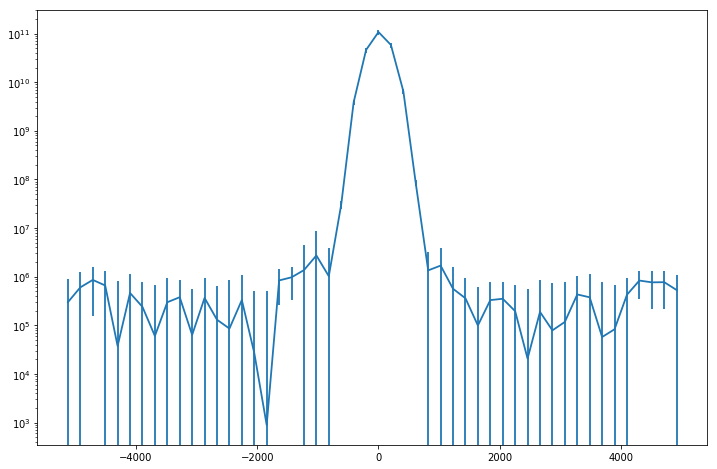

In [15]:
# Plot results
fig, ax = plt.subplots(figsize=(12,8))

# Get delays from the regular averaged UVPSpec object (they should all be the same)
dlys = uvp_avg.get_dlys(0) * 1e9 # Get delays [in ns] for spectral window 0

# Plot average power spectrum, plus bootstrap errorbars
ax.errorbar(dlys, np.abs(ps_avg.real).flatten(), yerr=ps_std, lw=1.8)
ax.set_yscale('log')